In [118]:
import xarray as xr
import numpy as np
import os
import scipy
import timeit
import time
import xesmf as xe

In [119]:
def concat_files(path_folder, experiment):
    if experiment == 'historical':
        yearEnd_first = 1970
        yearStart_last = 1999

    if experiment == 'rcp85':
        yearEnd_first = 2070
        yearStart_last = 2099

        
    files = [f for f in os.listdir(path_folder) if f.endswith('.nc')]
    if 'Amon' in path_folder:
        files = sorted(files, key=lambda x: x[x.index(".nc")-13:x.index(".nc")-9])
        files = [f for f in files if int(f[f.index(".nc")-13:f.index(".nc")-9]) <= yearStart_last and int(f[f.index(".nc")-6:f.index(".nc")-2]) >= yearEnd_first]
    else:
        files = [f for f in os.listdir(path_folder) if f.endswith('.nc')]
        files = sorted(files, key=lambda x: x[x.index(".nc")-17:x.index(".nc")-13])
        files = [f for f in files if int(f[f.index(".nc")-17:f.index(".nc")-13]) <= yearStart_last and int(f[f.index(".nc")-8:f.index(".nc")-4]) >= yearEnd_first]


    
    path_fileList = []
    for file in files:
        path_fileList = np.append(path_fileList, os.path.join(path_folder, file))

    ds = xr.open_mfdataset(path_fileList, combine='by_coords').sel(time=slice(str(yearEnd_first), str(yearStart_last)),lat=slice(-35,35))

    return ds

In [120]:
def regrid_conserv_xesmf(ds_in):
    ds_out = xr.open_dataset('/g/data/k10/cb4968/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')
    regridder = xe.Regridder(ds_in.isel(time=0), ds_out, 'conservative', periodic=True)

    return regridder

In [121]:
def get_clouds(institute, model, experiment):
    path_gen = '/g/data/al33/replicas/CMIP5/combined/'+ institute + '/' + model + '/' + experiment + '/mon/atmos/Amon'
    ensemble = 'r1i1p1'
    version = max(os.listdir(os.path.join(path_gen, ensemble)), key=lambda x: int(x.split("v")[-1]))
    variable = 'cl'
    path_folder =  os.path.join(path_gen, ensemble, version, variable)
    ds = concat_files(path_folder, experiment)
    regridder = regrid_conserv_xesmf(ds)
    
    clouds = ds['cl']
    clouds_n = regridder(clouds)

    pressureLevels = ds.a*ds.p0 + ds.b*ds.ps
    pressureLevels_n = regridder(pressureLevels)

    pressureLevels_low = xr.where((pressureLevels_n<=1000e2) & (pressureLevels_n>=600), 1, 0)
    cloud_low = clouds_n*pressureLevels_low
    cloud_low = cloud_low.max(dim='lev')
    cloud_low.attrs['units'] = '%'
    cloud_low.attrs['description'] = 'Maximum cloud fraction (%) from plev: 1000-600 hpa'

    pressureLevels_high = xr.where((pressureLevels_n<=250e2) & (pressureLevels_n>=100), 1, 0)
    cloud_high = clouds_n*pressureLevels_high
    cloud_high = cloud_high.max(dim='lev')
    cloud_high.attrs['units'] = '%'
    cloud_high.attrs['description'] = 'Maximum cloud fraction (%) from plev: 250-100 hpa'

    ds_clouds = xr.Dataset(
        data_vars = {
            'cloud_low': cloud_low, 
            'cloud_high': cloud_high},
        attrs = {'description': 'Metric defined as maximum cloud fraction (%) from specified pressure level intervals'}
        )
    
    return ds_clouds

In [122]:
institutes = {
    'IPSL-CM5A-MR':'IPSL',
    'GFDL-CM3':'NOAA-GFDL',
    'GISS-E2-H':'NASA-GISS',
    'bcc-csm1-1':'BCC',
    'CNRM-CM5':'CNRM-CERFACS',
    'CCSM4':'NCAR',
    'HadGEM2-AO':'NIMR-KMA',
    'BNU-ESM':'BNU',
    'EC-EARTH':'ICHEC',
    'FGOALS-g2':'LASG-CESS',
    'MPI-ESM-MR':'MPI-M',
    'CMCC-CM':'CMCC',
    'inmcm4':'INM',
    'NorESM1-M':'NCC',
    'CanESM2':'CCCma',
    'MIROC5':'MIROC',
    'HadGEM2-CC':'MOHC',
    'MRI-CGCM3':'MRI',
    'CESM1-BGC':'NSF-DOE-NCAR'
    }



models = [
        # 'IPSL-CM5A-MR', # 1
        'GFDL-CM3',      # 2
        # 'GISS-E2-H',    # 3
        # 'bcc-csm1-1',   # 4
        # 'CNRM-CM5',     # 5
        # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
        # 'HadGEM2-AO',   # 7
        # 'BNU-ESM',      # 8
        # 'EC-EARTH',     # 9
        # 'FGOALS-g2',    # 10
        # 'MPI-ESM-MR',   # 11
        # 'CMCC-CM',      # 12
        # 'inmcm4',       # 13
        # 'NorESM1-M',    # 14
        # 'CanESM2',      # 15 
        # 'MIROC5',       # 16
        # 'HadGEM2-CC',   # 17
        # 'MRI-CGCM3',    # 18
        # 'CESM1-BGC'     # 19
        ]
model = models[0]
institute = institutes[model]


experiments = [
            # 'historical',
            'rcp85'
            ]
experiment = experiments[0]



In [123]:
ds = get_clouds(institutes[model], model, experiment)
ds

<xarray.Dataset>
Dimensions:     (time: 360, lat: 22, lon: 128)
Coordinates:
  * time        (time) object 2070-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat         (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon         (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    cloud_low   (time, lat, lon) float64 dask.array<chunksize=(12, 22, 128), meta=np.ndarray>
    cloud_high  (time, lat, lon) float64 dask.array<chunksize=(12, 22, 128), meta=np.ndarray>
Attributes:
    description:  Metric defined as maximum cloud fraction (%) from specified...

In [145]:
    path_gen = '/g/data/al33/replicas/CMIP5/combined/'+ institute + '/' + model + '/' + experiment + '/mon/atmos/Amon'
    ensemble = 'r1i1p1'
    version = max(os.listdir(os.path.join(path_gen, ensemble)), key=lambda x: int(x.split("v")[-1]))
    variable = 'cl'
    path_folder =  os.path.join(path_gen, ensemble, version, variable)
    ds = concat_files(path_folder, experiment)
    regridder = regrid_conserv_xesmf(ds)
    
    clouds = ds['cl']
    clouds_n = regridder(clouds)

    pressureLevels = ds.a*ds.p0 + ds.b*ds.ps
    pressureLevels_n = regridder(pressureLevels)

    pressureLevels_low = xr.where((pressureLevels_n<=1000e2) & (pressureLevels_n>=600), 1, 0)
    cloud_low = clouds_n*pressureLevels_low
    cloud_low = cloud_low.max(dim='lev')
    cloud_low.attrs['units'] = '%'
    cloud_low.attrs['description'] = 'Maximum cloud fraction (%) from plev: 1000-600 hpa'

    pressureLevels_high = xr.where((pressureLevels_n<=250e2) & (pressureLevels_n>=100), 1, 0)
    cloud_high = clouds_n*pressureLevels_high
    cloud_high = cloud_high.max(dim='lev')
    cloud_high.attrs['units'] = '%'
    cloud_high.attrs['description'] = 'Maximum cloud fraction (%) from plev: 250-100 hpa'

    ds_clouds = xr.Dataset(
        data_vars = {
            'cloud_low': cloud_low, 
            'cloud_high': cloud_high},
        attrs = {'description': 'Metric defined as maximum cloud fraction (%) from specified pressure level intervals'}
        )

In [141]:
if cloud_low.equals(cloud_high):
    print("The data arrays are equal")
else:
    print("The data arrays are not equal")

The data arrays are not equal


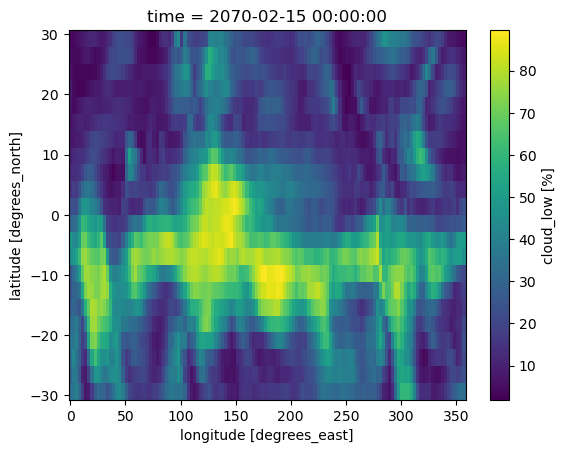

In [147]:
cloud_low.isel(time=1).plot()

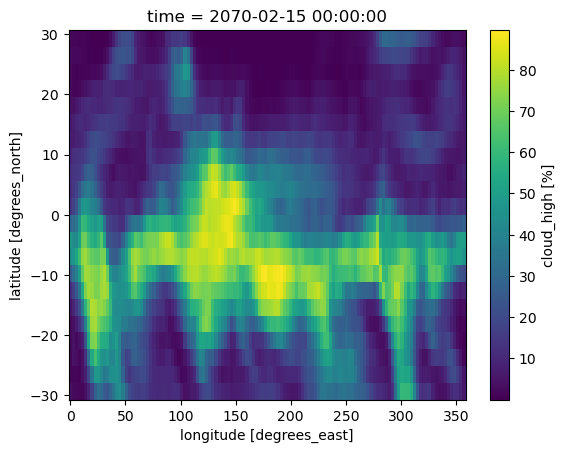

In [148]:
cloud_high.isel(time=1).plot()

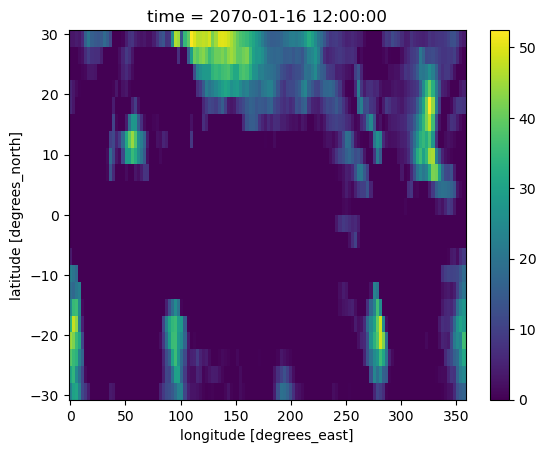

In [150]:
a= (cloud_low-cloud_high).isel(time=0).plot()